# Coefficients

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HugoMVale/polykin/main?labpath=docs%2Ftutorials%2Fcoefficients.ipynb)

## Overview

The `coefficients` module offers a number of classes to deal with the types of kinetic coefficients and physical property correlations most often found in polymer reactor models.

| Class                     | Required arguments | Optional arguments                    | Category               |
|---------------------------|--------------------|---------------------------------------|------------------------|
| Arrhenius                 | k0, EaR            | T0, Tmin, Tmax, Yunit, Ysymbol, name  | kinetics (generic)     |
| Eyring                    | DSa, DHa           | kappa, Tmin, Tmax, Ysymbol, name      | kinetics (generic)     |
| CompositeModelTermination | k11, icrit         | aS, aL, name                          | kinetics (termination) |
| DIPPR100                  | A, B, C, D, E      | Tmin, Tmax, Yunit, Ysymbol, name      | physical properties    |
| DIPPR101                  | A, B, C, D, E      | Tmin, Tmax, Yunit, Ysymbol, name      | physical properties    |
| DIPPR105                  | A, B, C, D         | Tmin, Tmax, Yunit, Ysymbol, name      | physical properties    |

The meanings of all arguments, along with their corresponding units, are thoroughly documented in the respective docstrings.

In [1]:
# Comment out the next line to install the package (e.g., in Google Colab)
# ! pip install polykin

## Kinetic coefficients

### Arrhenius and Eyring

In [2]:
from polykin.coefficients import Arrhenius, Eyring

To instantiate a kinetic coefficient, we call the respective class constructor with the desired argument values. Here are some examples of Arrhenius coefficients.

In [3]:
# Arrhenius coefficient defined in terms of pre-exponential factor (A) and Ea/R.
k1 = Arrhenius(1e10, 2e3)
# Arrhenius coefficient defined in terms of value at reference temperature (T0) and Ea/R.
k2 = Arrhenius(1e5, 2e3, T0=350.)
# Arrhenius coefficient including temperature limits, units and name.
kp = Arrhenius(1e3, 1.8e3, T0=350., Tmin=298., Tmax=350., Yunit='L/mol/s', Ysymbol='k_p', name='kp of M')
# Array of Arrhenius coefficients.
kd = Arrhenius([1e3, 2e3], [1.8e3, 4e3], T0=298., Tmin=273., Tmax=373., Ysymbol='k_d', Yunit='1/min',  name='kd(I1, I2)')

For Eyring coefficients, we proceed similarly, only with different arguments.

In [4]:
# Eyring coefficient defined in terms of entropy and enthalpy of activation.
k3 = Eyring(1e2, 1e4)
# Eyring coefficient including transmission factor, temperature limits and name.
k4 = Eyring(50., 1e4, kappa=0.8, Tmin=273., Tmax=373., Ysymbol='k_4', name='k of A->B')

The most important properties of a coefficient can be displayed with the `print()` command.

In [5]:
print(kd)

name:      kd(I1, I2)
symbol:    k_d
unit:      1/min
k0:        [1000. 2000.]
Ea/R [K]:  [1800. 4000.]
T0   [K]:  298.0
Tmin [K]:  273.0
Tmax [K]:  373.0


In [6]:
print(k4)

name:             k of A->B
symbol:           k_4
unit:             s^{-1}
DSa [J/(mol·K)]:  50.0
DHa [J/mol]:      10000.0
kappa [—]:        0.8
Tmin [K]:         273.0
Tmax [K]:         373.0


To evaluate a coefficient at a given temperature, we simply call the object with the temperature value (scalar or array-like) as the first positional argument. The temperature unit can be passed as second argument (default is °C). 

In [7]:
# Evaluate kp at 25°C
kp(25.)

408.86410508027456

In [8]:
# Evaluate kp at 298.15 K
kp(298.15, 'K')

408.86410508027456

In [9]:
# Evaluate kd at 50°C
kd(50.)

array([1600.15388708, 5684.89928869])

In [10]:
# Evaluate k3 at multiple temperatures (in °C)
k3([25., 50., 75.])

array([1.83950035e+16, 2.72398134e+16, 3.83386008e+16])

Evaluations outside the specified temperature range are not blocked, but raise a warning.

In [11]:
k4(110.)

113161553606897.12

Arrhenius coefficients have the special mathematical property that a product of two Arrhenius coefficients is also an Arrhenius coefficient. The `Arrhenius` class includes this intrisic feature.

In [12]:
kp1 = Arrhenius(1e3, 2e3, T0 = 350., Ysymbol='k_{p1}', name='kp1')
Cm1 = Arrhenius(1e-3, 1e3, T0 = 300., Ysymbol='C_{m1}', name='Cm1')
f = Arrhenius(1., 5e2, T0 = 320., Ysymbol='f', name='fudge factor')
kfm1 = Cm1*kp1/f
# kfm1 is now a coefficient and can be used as such
kfm1([25., 50.])

array([0.40660136, 0.77784632])

### CompositeModelTermination

In [13]:
from polykin.coefficients import CompositeModelTermination

This class implements the chain-length-dependent composite termination model proposed by Smith and Russel (2003). Note that the class only describes the chain-length effect; the temperature effect must be described separtely (e.g., by `Arrhenius` or `Eyring`). 

In [14]:
kt11 = Arrhenius(1e9, 2e3, T0=298., name='kt(1,1)')
kt = CompositeModelTermination(kt11, icrit=30, name='kt(T,i,j)')

In [15]:
# kt at 25°C between radicals with chain lengths 150 and 200
kt(25., 150, 200)

129008375.03821689

The internal functions are vectorized, so the arguments can also be arrays. For example, we can create a contour plot of kt with just a few lines of code.

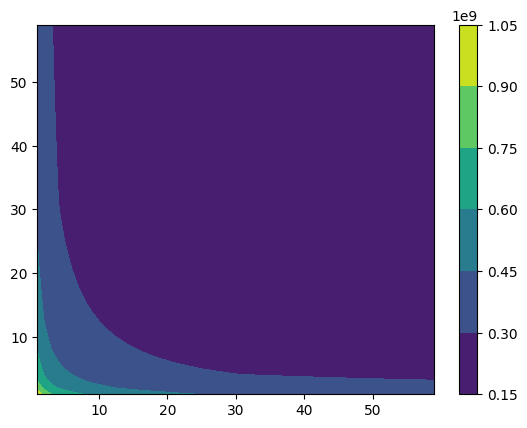

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# create mesh of chain-lengths
irange = np.arange(1, 60)
jrange = irange
mesh = np.meshgrid(irange, jrange)
# evaluate kt for mesh
kt_result = kt(25, mesh[0], mesh[1])
# make contour plot
plt.contourf(irange, jrange, kt_result)
plt.colorbar()

## DIPPR correlations

In [17]:
from polykin.coefficients import DIPPR100, DIPPR101, DIPPR105

DIPPR equations are used to correlate all sorts of physical properties. To instantiate an object, we call the respective class constructor with the desired argument values. Here are some examples for each of the DIPPR equations presently implemented.

In [18]:
# Water cp using DIPPR-100
cp_water = DIPPR100(276370., -2090.1, 8.125, -0.014116, 0.0000093701, Yunit='J/kmol/K', Ysymbol='C_p', name='Cp of water')
# Water vapor pressure using DIPPR-101
pvap_water = DIPPR101(73.649, -7258.2, -7.3037, 4.1653E-6, 2., Yunit='Pa', Ysymbol=r'P_{vap}', name='Vapor pressure of water')
# Water density using DIPPR-105
density_water = DIPPR105(0.14395, 0.0112, 649.727, 0.05107, Tmin=273., Tmax=648., Yunit='kg/m3', Ysymbol=r'\rho', name='Density of water')

In [19]:
cp_water(25.)/18.02

4183.363133587069

In [20]:
pvap_water(373.15, 'K')/1e5

1.0126056298096628

In [21]:
density_water(25.)

998.9463920931878

In [22]:
print(density_water)

name:      Density of water
symbol:    \rho
unit:      kg/m3
A:         0.14395
B:         0.0112
C:         649.727
D:         0.05107
Tmin [K]:  273.0
Tmax [K]:  648.0


All equations are vectorized to facilitate evaluation at multiple temperatures. 

In [23]:
density_water([0., 50., 100.])

array([1014.34627215,  982.72892731,  947.3649398 ])

## Plots

`Arrhenius`, `Eyring`, and all `DIPPR` subclasses come with a convenient built-in method called `plot()`, enabling a rapid visualization of the corresponding kinetic or property models.

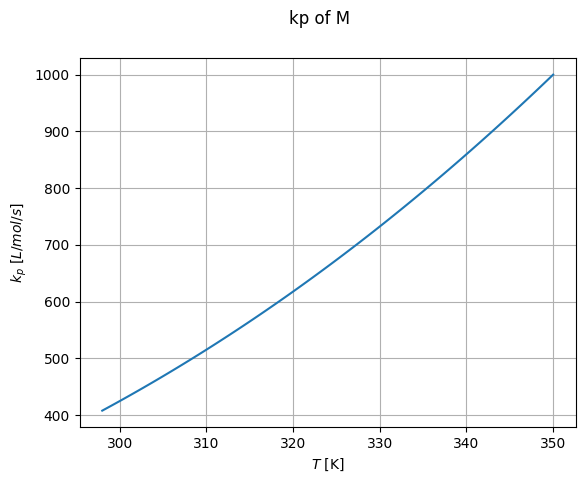

In [24]:
# Default ('linear') plot of kp over the validity range 
kp.plot()

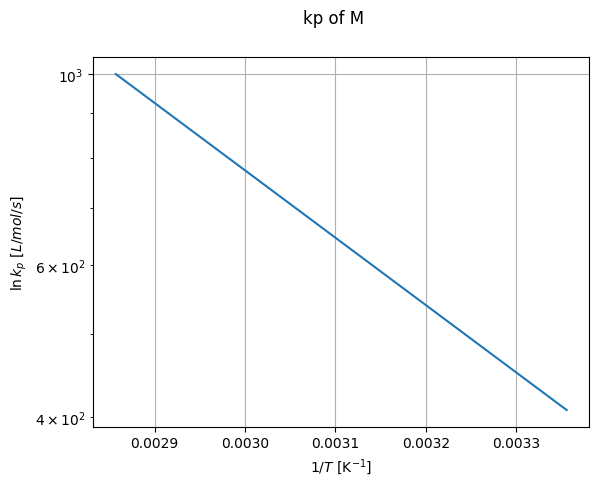

In [25]:
# Arrhenius plot of kp over the validity range 
kp.plot(kind='Arrhenius')

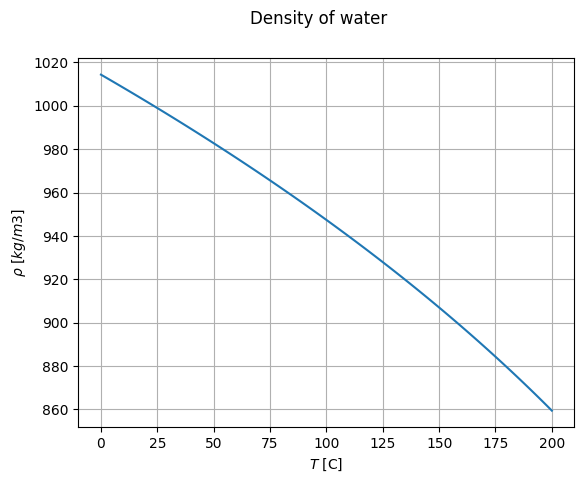

In [26]:
# plot density of water from 0-200°C
density_water.plot(Trange=(0., 200.), Tunit='C')

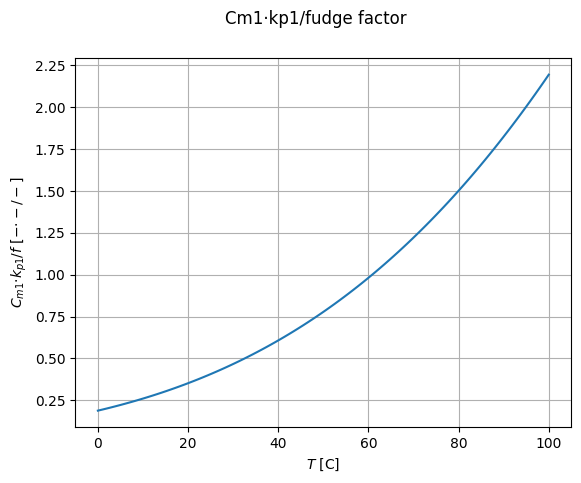

In [27]:
# If no temperature range is known, the plot range defaults to 0-100°C
kfm1.plot(Tunit='C')